**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Nested CV](#2-bullet)

## 1. [Libraries and settings](#1-bullet)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190 entries, 0 to 1189
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1190 non-null   float64
 1   High         1190 non-null   float64
 2   Low          1190 non-null   float64
 3   Close        1190 non-null   float64
 4   Volume       1190 non-null   int64  
 5   TradingDate  1190 non-null   object 
 6   Code         1190 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 74.4+ KB


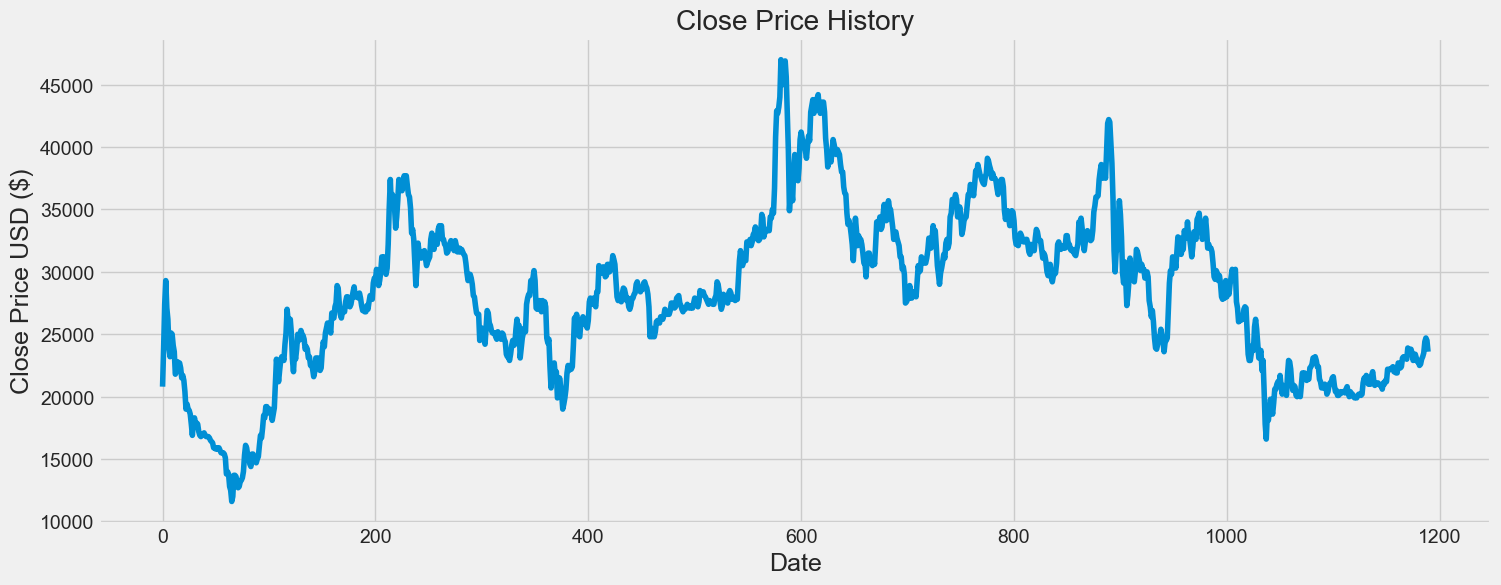

In [1]:
from DataPreprocessing import *

## 2. [Nested CV - Day Forward Chaining](#2-bullet)

We try to use nested CV for time series to try to tune hyperparameters. After getting best hyperparameters, we retrain model and then evaluate

### Create dataset

In [2]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train = x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

### Day forward chaining

In [4]:
def performSVR(X_train, Y_train, X_test, Y_test, parameters):

    # Create and train the SVR model
    svr_model = SVR(C = parameters['C'], kernel = parameters['kernel'], gamma = parameters['gamma'])
    svr_model.fit(X_train, Y_train)

    # Make predictions on the test set
    Y_pred_train = svr_model.predict(X_train)
    Y_pred_test = svr_model.predict(X_test)

    # Calculate accuracy
    accuracy_train = r2_score(Y_train, Y_pred_train)
    accuracy_valid = r2_score(Y_test, Y_pred_test)
    
    mse_train = mean_squared_error(Y_train, Y_pred_train)
    mse_valid = mean_squared_error(Y_test, Y_pred_test)
    
    return [accuracy_train, accuracy_valid, mse_train, mse_valid]

In [5]:
from sklearn.model_selection import ParameterGrid

def performDayForwardChaining(X_train, y_train, number_folds):
    # Định nghĩa siêu tham số để tinh chỉnh
    param_grid = {
        'C': [0.01, 0.1, 1, 100],
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'gamma' : [0.01, 0.001, 1]
    }

    # Chuyển đổi siêu tham số thành danh sách các tham số có thể
    param_list = list(ParameterGrid(param_grid))
    
    print('Size train set: ', X_train.shape)
    
    # k is the size of each fold. It is computed dividing the number of 
    # rows in X_train by number_folds. This number is floored and coerced to int
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: ', k)
    
    results_valid = []
    results_test = []
    # loop from the first 2 folds to the total number of folds    
    for i in range(3, number_folds + 1):
        print('')
        
        split = float(i-1)/i
        
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i))

        X = X_train[:(k*i),:]
        y = y_train[:(k*i),:]
        print('Size of train + valid + test: ', X.shape) 

        index = int(np.floor(X.shape[0] * split))
        print(index)
        
        # folds used to train the model        
        X_train_validFolds = X[:index,:]        
        y_train_validFolds = y[:index,:]
        
        index_valid = int((i-2)*index/(i-1))
        
        X_trainFolds = X_train_validFolds[:index_valid,:]
        y_trainFolds = y_train_validFolds[:index_valid,:]
        
        X_validFolds = X_train_validFolds[index_valid:,:]
        y_validFolds = y_train_validFolds[index_valid:,:]
        
        # fold used to test the model
        X_testFolds = X[(index + 1):,:]
        y_testFolds = y[(index + 1):,:]
        
        for j,params in enumerate(param_list):
            print(f"Evaluating parameters {j+1}: {params}")
            accuracies_valid = performSVR(X_trainFolds, y_trainFolds, X_validFolds, y_validFolds, params)
            
            results_valid.append({
            'parameters': params,
            'accuracy_train': accuracies_valid[0],
            'accuracy_valid': accuracies_valid[1],
            'mse_train': accuracies_valid[2],
            'mse_valid': accuracies_valid[3]
            })

        for result in results_valid:
            print("Parameters: ", result['parameters'])
            print("Train Accuracy: ", result['accuracy_train'])
            print("Valid Accuracy: ", result['accuracy_valid'])
            print("Train MSE: ", result['mse_train'])
            print("Valid MSE: ", result['mse_valid'])
            print("------------------------")
        
        # Sắp xếp danh sách kết quả theo trường 'accuracy_valid' tăng dần
        sorted_results_valid = sorted(results_valid, key=lambda x: x['mse_valid'], reverse=False)

        # Lấy bộ tham số đầu tiên từ danh sách đã sắp xếp
        best_parameters = sorted_results_valid[0]['parameters']
        print(best_parameters)
        
        accuracies_test = performSVR(X_train_validFolds, y_train_validFolds, X_testFolds, y_testFolds, best_parameters)
        
        results_test.append({
            'parameters': best_parameters,
            'accuracy_train': accuracies_test[0],
            'accuracy_test': accuracies_test[1],
            'mse_train': accuracies_test[2],
            'mse_test': accuracies_test[3]
            })
        
    acc_train_model = 0
    acc_test_model = 0
    mse_train_model = 0
    mse_test_model = 0
    cnt = 0
    for result in results_test:
        acc_train_model += result['accuracy_train']
        acc_test_model += result['accuracy_test']
        mse_train_model += result['mse_train']
        mse_test_model += result['mse_test']
        cnt += 1

    acc_train_model = acc_train_model/cnt
    acc_test_model = acc_test_model/cnt
    mse_train_model = mse_train_model/cnt
    mse_test_model = mse_test_model/cnt
    # the function returns the mean of the accuracy on the n-1 folds    
    return acc_train_model, acc_test_model, mse_train_model, mse_test_model

In [6]:
accuracy_train_model, accuracy_test_model, mse_train_model, mse_test_model = performDayForwardChaining(x_for_train, y_for_train, number_folds=5)

print("Train Accuracy Model: ", accuracy_train_model)
print("Test Accuracy Model: ", accuracy_test_model)
print("Train MSE Model: ", mse_train_model)
print("Test MSE Model: ", mse_test_model)
print("------------------------")
   

Size train set:  (1159, 30)
Size of each fold:  231

Splitting the first 3 chunks at 2/3
Size of train + valid + test:  (693, 30)
462
Evaluating parameters 1: {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}
Evaluating parameters 2: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluating parameters 3: {'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}
Evaluating parameters 4: {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
Evaluating parameters 5: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
Evaluating parameters 6: {'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}
Evaluating parameters 7: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
Evaluating parameters 8: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
Evaluating parameters 9: {'C': 0.01, 'gamma': 1, 'kernel': 'sigmoid'}
Evaluating parameters 10: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Evaluating parameters 11: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluating parameters 12: {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
Evaluating param

Evaluating parameters 5: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
Evaluating parameters 6: {'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}
Evaluating parameters 7: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
Evaluating parameters 8: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
Evaluating parameters 9: {'C': 0.01, 'gamma': 1, 'kernel': 'sigmoid'}
Evaluating parameters 10: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Evaluating parameters 11: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluating parameters 12: {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
Evaluating parameters 13: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Evaluating parameters 14: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Evaluating parameters 15: {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
Evaluating parameters 16: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Evaluating parameters 17: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Evaluating parameters 18: {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
Evaluating para


Splitting the first 5 chunks at 4/5
Size of train + valid + test:  (1155, 30)
924
Evaluating parameters 1: {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}
Evaluating parameters 2: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluating parameters 3: {'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}
Evaluating parameters 4: {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
Evaluating parameters 5: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
Evaluating parameters 6: {'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}
Evaluating parameters 7: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
Evaluating parameters 8: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
Evaluating parameters 9: {'C': 0.01, 'gamma': 1, 'kernel': 'sigmoid'}
Evaluating parameters 10: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Evaluating parameters 11: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluating parameters 12: {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
Evaluating parameters 13: {'C': 0.1, 'gamma': 0.001, 'kernel': 'lin

Train Accuracy Model:  0.9841109523300785
Test Accuracy Model:  0.9600344130105375
Train MSE Model:  0.014798001858314222
Test MSE Model:  0.018321771222663947
------------------------
